# Segmentation of Indian Traffic

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path                   
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [ ]:
import urllib.request

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15276748818028878111
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12135141537367675958
physical_device_desc: "device: XLA_CPU device"
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#https://drive.google.com/drive/folders/1bynkOIXCurhJ9_Y5Q14KWX5yDyCRkKfN
!unzip '/content/drive/MyDrive/segmentation/data.zip' -d '/content'

Archive:  /content/drive/MyDrive/segmentation/data.zip
replace /content/data/images/201/frame0029_leftImg8bit.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
image_dir='data/images'
image_list=[]
for i in sorted(os.listdir(image_dir)):
    # print(i)
    folder_dir=os.path.join(image_dir,i)
    for image in sorted(os.listdir(folder_dir)):
        image_directory=os.path.join(folder_dir,image)
        image_list.append(image_directory)
mask_dir='data/mask'
mask_list=[]
for i in sorted(os.listdir(mask_dir)):
  # print(i)
  folder_dir=os.path.join(mask_dir,i)
  for mask in sorted(os.listdir(folder_dir)):
    mask_directory=os.path.join(folder_dir,mask)
    mask_list.append(mask_directory)

In [ ]:
import pandas as pd
data_df= pd.DataFrame(columns=['image','json'])

In [ ]:
data_df['image']=image_list
data_df['json']=mask_list

In [ ]:
data_df.head()

image  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  
0  data/mask/201/frame0029_gtFine_polygons.json  
1  data/mask/201/frame0299_gtFine_polygons.json  
2  data/mask/201/frame0779_gtFine_polygons.json  
3  data/mask/201/frame1019_gtFine_polygons.json  
4  data/mask/201/frame1469_gtFine_polygons.json

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
import json
def return_unique_labels(data_df):
    labels=[]
    for ind in data_df.json:
      f = open(ind,)
      data = json.load(f)
      for i in data['objects']:
        for j,k in i.items():
          if(j=='label'):
            labels.append(k)
      f.close()
    unique_labels=set(labels)
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
  label=[]
  vertexlist=[]
  f = open(file,)
  data = json.load(f)
  for i in data['objects']:
    for j,k in i.items():
      if(j=='label'):
        label.append(k)
  for i in data['objects']:
    for j,k in i.items():
      if(j=='polygon'):
        g=[]
        for item in k:
          g.append(tuple(item))
        vertexlist.append(g)
  w=data['imgWidth']
  h=data['imgHeight']
  return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

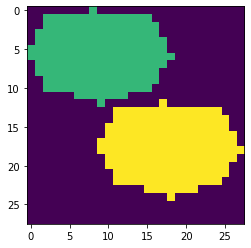

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
def compute_masks(data_df):
    mask=[]
    for file in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(file)
        img= Image.new("RGB",(w,h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(labels)):
            if(len(vertexlist[i])>1):
               img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        new_file=file.replace('mask','output')
        new_file=new_file.replace('json','png')
        os.makedirs('data/output/'+file.split('/')[2],exist_ok=True)
        im.save(new_file)
        mask.append(new_file)
    data_df['mask']=mask
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:54<00:00, 13.62it/s]


image  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  \
0  data/mask/201/frame0029_gtFine_polygons.json   
1  data/mask/201/frame0299_gtFine_polygons.json   
2  data/mask/201/frame0779_gtFine_polygons.json   
3  data/mask/201/frame1019_gtFine_polygons.json   
4  data/mask/201/frame1469_gtFine_polygons.json   

                                            mask  
0  data/output/201/frame0029_gtFine_polygons.png  
1  data/output/201/frame0299_gtFine_polygons.png  
2  data/output/201/frame0779_gtFine_polygons.png  
3  data/output/201/frame1019_gtFine_polygons.png  
4  data/output/201/frame1469_gtFine_polygons.png

In [ ]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
!pip install opencv-python

In [ ]:
import cv2

False
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


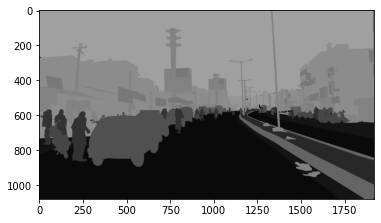

In [ ]:
def grader_3():
  url = "https://i.imgur.com/4XSUlHk.png"
  url_response = urllib.request.urlopen(url)
  img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, -1)
  my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')
  plt.imshow(my_img)
  print((my_img[:,:,0]==img).all())
  print(np.unique(img))
  print(np.unique(my_img[:,:,0]))
  data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [ ]:
#!pip install -U segmentation-models==0.2.1

In [ ]:
#!pip install keras==2.3.1

In [ ]:
#!pip install imgaug

In [ ]:
#!pip install imagecorruptions

In [ ]:
"""import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'"""

"import tensorflow as tf\n# tf.enable_eager_execution()\nimport os\nimport numpy as np\nimport pandas as pd\nimport cv2\nimport matplotlib.pyplot as plt\n# from hilbert import hilbertCurve\nimport numpy as np\n# import albumentations as A\nos.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'"

In [ ]:
"""#!pip install -U -q segmentation-models
#!pip install -q tensorflow==2.2.0
#!pip install -q keras==2.3.1
#!pip install -q tensorflow-estimator==2.2.0
#!pip install -q h5py==2.10.0
## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
#import segmentation_models as sm"""

'#!pip install -U -q segmentation-models\n#!pip install -q tensorflow==2.2.0\n#!pip install -q keras==2.3.1\n#!pip install -q tensorflow-estimator==2.2.0\n#!pip install -q h5py==2.10.0\n## Imports libs\nimport os\nos.environ[\'CUDA_VISIBLE_DEVICES\'] = \'0\'\nos.environ["SM_FRAMEWORK"] = "tf.keras"\nfrom tensorflow import keras\n#import segmentation_models as sm'

In [ ]:
#import segmentation_models as sm
#!pip install -U segmentation-models==0.2.1
#from tensorflow.keras.layers import InputSpec
import segmentation_models as sm
import keras

# sm.set_framework('tf.keras')
#!pip install tensorflow_core.keras
#tf.keras.backend.set_image_data_format('channels_last')
keras.backend.set_image_data_format('channels_last')

#from tensorflow import keras
#from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.models import Model, load_model
model = sm.Unet('mobilenetv2', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3))

/usr/local/lib/python3.7/dist-packages/segmentation_models/backbones/mobilenetv2.py:274: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.33, random_state=42)

In [ ]:
import imgaug.augmenters as iaa
aug1 = iaa.Fliplr(1)
aug2 = iaa.Flipud(1)
aug3 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))
CLASSES = list(np.unique(list(label_clr.values())))
print(CLASSES)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [ ]:
CL = list(label_clr.keys())
print(CL)
print(len(CL))

['road', 'parking', 'drivable fallback', 'sidewalk', 'non-drivable fallback', 'rail track', 'person', 'animal', 'rider', 'motorcycle', 'bicycle', 'autorickshaw', 'car', 'truck', 'bus', 'vehicle fallback', 'trailer', 'caravan', 'curb', 'wall', 'fence', 'guard rail', 'billboard', 'traffic sign', 'traffic light', 'pole', 'polegroup', 'obs-str-bar-fallback', 'building', 'bridge', 'tunnel', 'vegetation', 'sky', 'fallback background', 'unlabeled', 'out of roi', 'ego vehicle', 'ground', 'rectification border', 'train']
40


In [ ]:
import tensorflow as tf
def visualize(**images):
  n = len(images)
  plt.figure(figsize=(16, 5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    if i==1:
       plt.imshow(image, cmap='gray', vmax=1, vmin=0)
    else:
       plt.imshow(image)
  plt.show()
class Dataset:
  CLASSES = list(np.unique(list(label_clr.values())))
  # the parameters needs to changed based on your requirements
  # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
  # ex: fil_name.jpg file_name.mask.jpg
  def __init__(self , basepath , images_file_names , mask_file_names , CLASSES):
    self.image_ids = images_file_names
    self.mask_ids = mask_file_names
    # the paths of images
    self.images_fps = [os.path.join(basepath,image_id) for image_id in self.image_ids]
    # the paths of segmentation images
    self.masks_fps = [os.path.join(basepath,mask_id) for mask_id in self.mask_ids]
    # giving labels for each class
    self.CLASSES= CLASSES
    self.class_values = CLASSES
  def __getitem__(self, i):
      # read data
      image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
      image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
      image_mask = cv2.resize(mask,(256,256))
      image_masks = [(image_mask == v) for v in self.class_values]
      image_mask = np.stack(image_masks, axis=-1).astype('float')
      if self.images_fps[i] in X_train:
        a = np.random.uniform()
        if a<0.2:
          image = aug2.augment_image(image)
          image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
          image = aug3.augment_image(image)
          image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
          image = aug4.augment_image(image)
          image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
          image = aug5.augment_image(image)
          image_mask = image_mask
        else:
          image = aug6.augment_image(image)
          image_mask = aug6.augment_image(image_mask)
      return image, image_mask
  def __len__(self):
    return len(self.image_ids)
class Dataloder(tf.keras.utils.Sequence):
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))
  def __getitem__(self, i):
      # collect batch data
      start = i * self.batch_size
      stop = (i + 1) * self.batch_size
      data = []
      for j in range(start, stop):
        data.append(self.dataset[j])
      batch = [np.stack(samples, axis=0) for samples in zip(*data)]
      return tuple(batch)
  def __len__(self):
      return len(self.indexes) // self.batch_size
  def on_epoch_end(self):
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)

In [ ]:
from segmentation_models.metrics import iou_score
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])
CLASSES = list(np.unique(list(label_clr.values())))
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.callbacks import TensorBoard
import datetime
!rm -rf '/content/logs'
CLASSES = CLASSES
basepath = '/content/'
train_dataset = Dataset(basepath, X_train['image'].values, X_train['mask'].values, CLASSES=CLASSES)
test_dataset = Dataset(basepath, X_test['image'].values, X_test['mask'].values, CLASSES=CLASSES)
train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb= tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
checkpoint = ModelCheckpoint('./best_model.h5', save_weights_only=True,save_best_only=True,monitor='val_accuracy', mode='min')
red = ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)
callbacks_list =[checkpoint,tensorboard_cb,red,]

(8, 256, 256, 3)
(8, 256, 256, 21)


In [ ]:
len(train_dataloader)

335

In [7]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5, epochs=5,validation_data=test_dataloader,callbacks=callbacks_list)
print('Epoch 1/5')
print('335/335 [==============================] - 275s 822ms/step - loss: 0.3440 - iou_score: 0.5617 - val_loss: 0.3903- val_iou_score: 0.5169 - lr: 1.0000e-05')
print('Epoch 2/5')
print('335/335 [==============================] - 274s 819ms/step - loss: 0.3429 - iou_score: 0.5628 - val_loss: 0.3863- val_iou_score: 0.5212 - lr: 1.0000e-05')
print('Epoch 3/5')
print('335/335 [==============================] - 278s 831ms/step - loss: 0.3421 - iou_score: 0.5637 - val_loss: 0.3845- val_iou_score: 0.5232 - lr: 1.0000e-06')
print('Epoch 4/5')
print('335/335 [==============================] - 286s 855ms/step - loss: 0.3420 - iou_score: 0.5637 - val_loss: 0.3837- val_iou_score: 0.5242 - lr: 1.0000e-06')
print('Epoch 5/5')
print('335/335 [==============================] - 285s 849ms/step - loss: 0.3419 - iou_score: 0.5638 - val_loss: 0.3833- val_iou_score: 0.5247 - lr: 1.0000e-06')


Epoch 1/5
335/335 [==============================] - 275s 822ms/step - loss: 0.3440 - iou_score: 0.5617 - val_loss: 0.3903- val_iou_score: 0.5169 - lr: 1.0000e-05
Epoch 2/5
335/335 [==============================] - 274s 819ms/step - loss: 0.3429 - iou_score: 0.5628 - val_loss: 0.3863- val_iou_score: 0.5212 - lr: 1.0000e-05
Epoch 3/5
335/335 [==============================] - 278s 831ms/step - loss: 0.3421 - iou_score: 0.5637 - val_loss: 0.3845- val_iou_score: 0.5232 - lr: 1.0000e-06
Epoch 4/5
335/335 [==============================] - 286s 855ms/step - loss: 0.3420 - iou_score: 0.5637 - val_loss: 0.3837- val_iou_score: 0.5242 - lr: 1.0000e-06
Epoch 5/5
335/335 [==============================] - 285s 849ms/step - loss: 0.3419 - iou_score: 0.5638 - val_loss: 0.3833- val_iou_score: 0.5247 - lr: 1.0000e-06


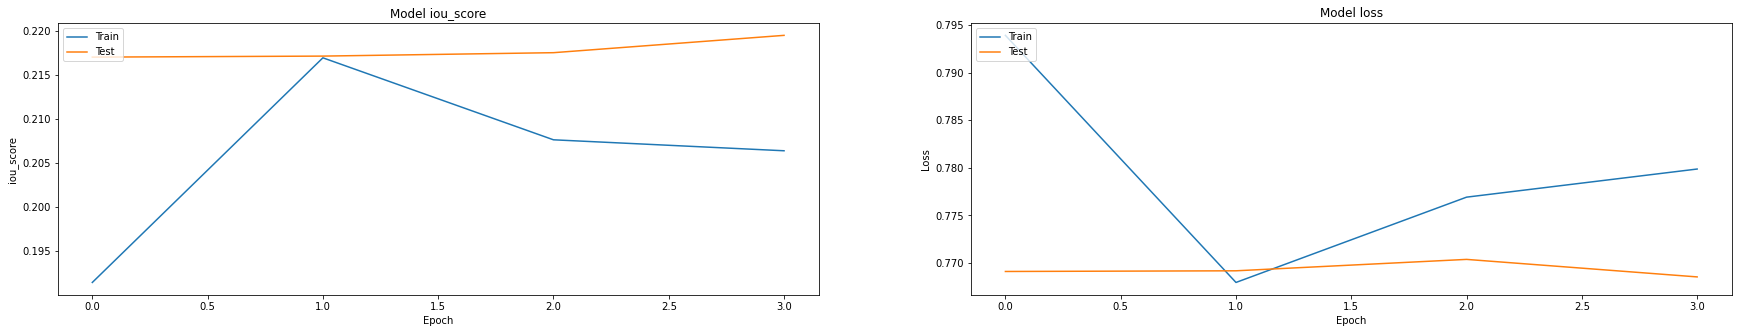

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

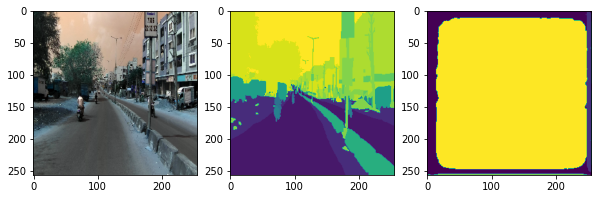

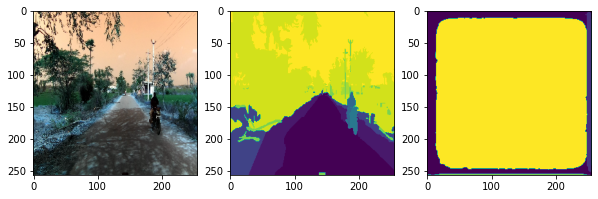

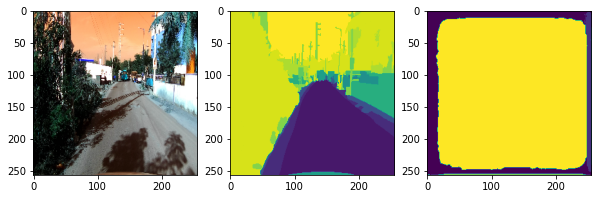

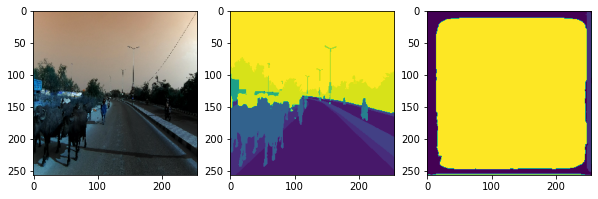

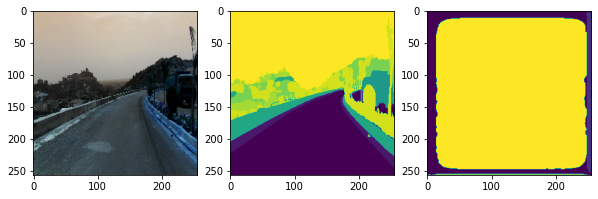

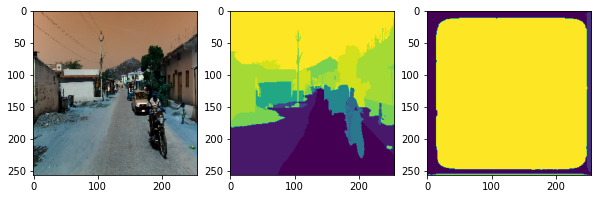

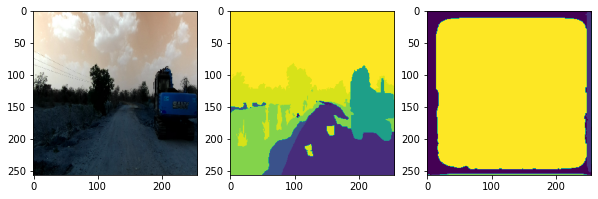

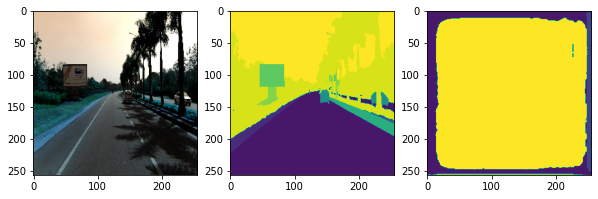

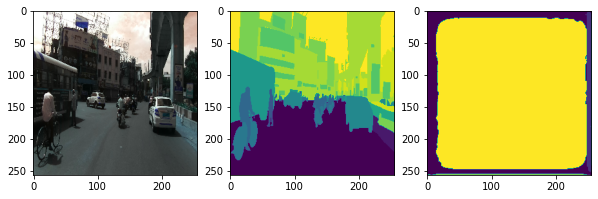

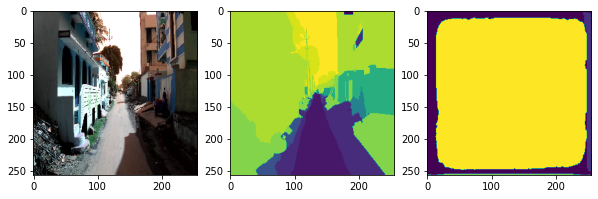

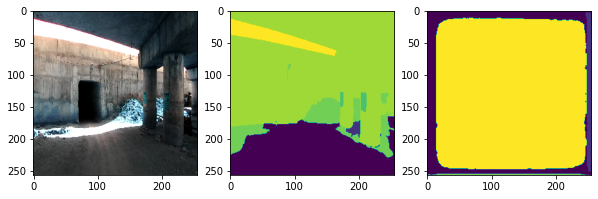

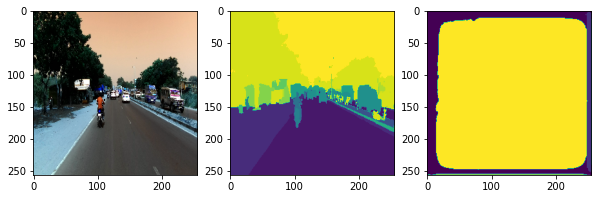

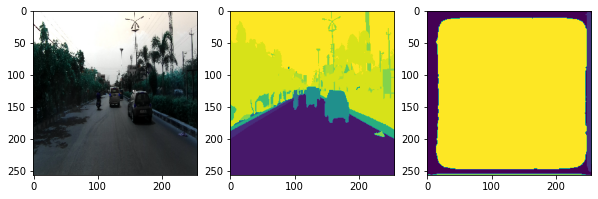

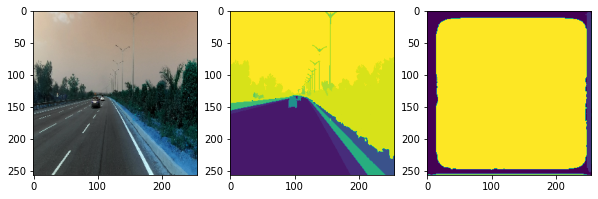

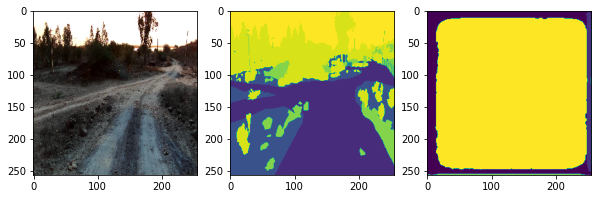

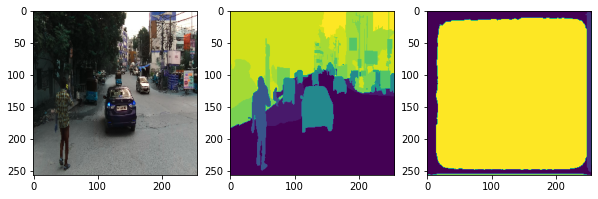

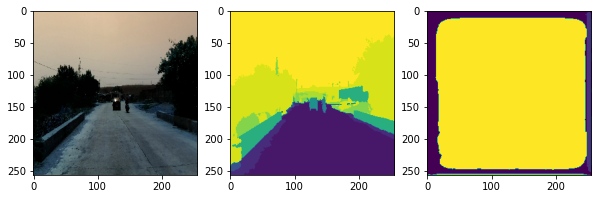

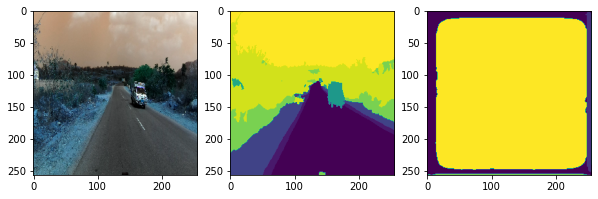

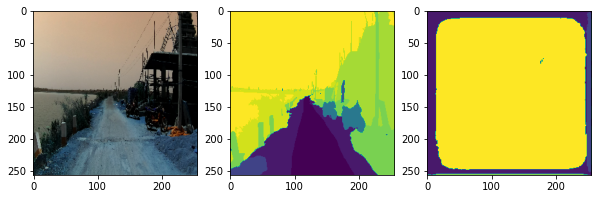

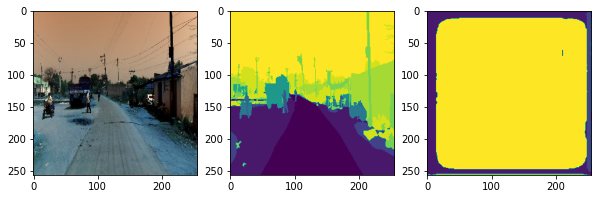

In [ ]:
a=0
for i in range(len(X_test)):
  a+=1
  #original image
  image = cv2.imread(list(X_test['image'])[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST)
  #predicted segmentation map
  pred_mask = model.predict(image[np.newaxis,:,:,:])
  pred_mask = tf.argmax(pred_mask, axis=-1)
  #original segmentation map
  image_mask = cv2.imread(list(X_test['mask'])[i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.subplot(133)
  plt.imshow(pred_mask[0])
  plt.show()
  if a==20:
    break

# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [ ]:
#https://blog.paperspace.com/understanding-canet-architecture/
class convolutional_block(tf.keras.layers.Layer):
  def __init__(self, kernel=3, filters=[4,4,8], stride=1, name="conv block"):
    super().__init__(convolutional_block)
    self.F1, self.F2, self.F3 = filters
    self.kernel = kernel
    self.stride = stride
    self.conv_1 = Conv2D(self.F1,(1,1),strides=(self.stride,self.stride),padding='same')
    self.conv_2 = Conv2D(self.F2,(self.kernel,self.kernel),strides=(1,1),padding='same')
    self.conv_3 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same')
    self.conv_4 = Conv2D(self.F3,(self.kernel,self.kernel),strides=(self.stride,self.stride),padding='same')
    self.bn1 = BatchNormalization(axis=3)
    self.bn2 = BatchNormalization(axis=3)
    self.bn3 = BatchNormalization(axis=3)
    self.bn4 = BatchNormalization(axis=3)
    self.activation = Activation("relu")
    self.add = Add()
  def call(self, X):
    # write the architecutre that was mentioned above
    X_input = X
    # First Convolutional Block
    conv1 = self.conv_1(X)
    bn1 = self.bn1(conv1)
    act1 = self.activation(bn1)
    # Second Convolutional Block
    conv2 = self.conv_2(act1)
    bn2 = self.bn2(conv2)
    act2 = self.activation(bn2)
    # Third Convolutional Block
    conv3 = self.conv_3(act2)
    bn3 = self.bn3(conv3)
    # Adjusting the input
    X_input = self.conv_4(X_input)
    X_input = self.bn4(X_input)
    X_input = self.activation(X_input)
    # Re-add the input
    X = self.add([bn3, X_input])
    X = self.activation(X)
    return X

In [ ]:
#https://blog.paperspace.com/understanding-canet-architecture/
class identity_block(tf.keras.layers.Layer):
  def __init__(self, kernel=3, filters=[4,4,8], name="identity block"):
    super().__init__(identity_block)
    self.F1, self.F2, self.F3 = filters
    self.kernel = kernel
    self.conv_1 = Conv2D(self.F1, (1,1), (1,1), padding="same")
    self.conv_2 = Conv2D(self.F2, (self.kernel,self.kernel), (1,1), padding="same")
    self.conv_3 = Conv2D(self.F3, (1,1), (1,1), padding="same")
    self.bn1 = BatchNormalization(axis=3)
    self.bn2 = BatchNormalization(axis=3)
    self.bn3 = BatchNormalization(axis=3)
    self.activation = Activation("relu")
    self.add = Add()
  def call(self, X):
    # write the architecutre that was mentioned above
    X_input = X
    conv1 = self.conv_1(X)
    bn1 = self.bn1(conv1)
    act1 = self.activation(bn1)
    conv2 = self.conv_2(act1)
    bn2 = self.bn2(conv2)
    act2 = self.activation(bn2)
    conv3 = self.conv_3(act2)
    bn3 = self.bn3(conv3)
    X = self.add([bn3, X_input])
    X = self.activation(X)
    return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
#https://blog.paperspace.com/understanding-canet-architecture/
class global_flow(tf.keras.layers.Layer):
  def __init__(self, input_dim, output_dim, channels, name="global_flow"):
    super().__init__(global_flow)
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.channels = channels
    self.conv1 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same')
    self.global_avg_pool = GlobalAveragePooling2D()
    self.bn = BatchNormalization(axis=3)
    self.activation = Activation("relu")
    self.upsample = UpSampling2D(size=(self.input_dim,self.output_dim),interpolation='bilinear')
  def call(self, X):
    # implement the global flow operatiom
    global_avg = self.global_avg_pool(X)
    global_avg= tf.expand_dims(global_avg, 1)
    global_avg = tf.expand_dims(global_avg, 1)
    bn1 = self.bn(global_avg)
    act1 = self.activation(bn1)
    conv1 = self.conv1(act1)
    X = self.upsample(conv1)
    return X

In [ ]:
#https://blog.paperspace.com/understanding-canet-architecture/
class context_flow(tf.keras.layers.Layer):
  def __init__(self, name="context_flow"):
    super().__init__(context_flow)
    self.conv_1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
    self.conv_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
    self.conv_3 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
    self.conv_4 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
    self.concatenate = Concatenate()
    self.avg_pool = AveragePooling2D(pool_size=(2,2))
    self.activation_relu = Activation("relu")
    self.activation_sigmoid = Activation("sigmoid")
    self.add = Add()
    self.multiply = Multiply()
    self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
  def call(self, X):
    # here X will a list of two elements
    INP, FLOW = X[0], X[1]
    # implement the context flow as mentioned in the above cell
    # Context Fusion Module
    concat = self.concatenate([INP, FLOW])
    avg_pooling = self.avg_pool(concat)
    conv1 = self.conv_1(avg_pooling)
    conv2 = self.conv_2(conv1)
    # Context Refinement Module
    conv3 = self.conv_3(conv2)
    act1 = self.activation_relu(conv3)
    conv4 = self.conv_4(act1)
    act2 = self.activation_sigmoid(conv4)
    # Combining and upsampling
    multi = self.multiply([conv2, act2])
    add = self.add([conv2, multi])
    X = self.upsample(add)
    return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
#https://blog.paperspace.com/understanding-canet-architecture/
class fsm(tf.keras.layers.Layer):
  def __init__(self, name="feature_selection"):
    super().__init__(fsm)
    self.conv_1 = Conv2D(32, (3,3), (1,1), padding="same")
    self.global_avg_pool = GlobalAveragePooling2D()
    self.conv_2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
    self.bn = BatchNormalization()
    self.act_sigmoid = Activation('sigmoid')
    self.multiply = Multiply()
    self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
  def call(self, X):
    X = self.conv_1(X)
    global_avg = self.global_avg_pool(X)
    global_avg= tf.expand_dims(global_avg, 1)
    global_avg = tf.expand_dims(global_avg, 1)
    conv1= self.conv_2(global_avg)
    bn1= self.bn(conv1)
    Y = self.act_sigmoid(bn1)
    output = self.multiply([X, Y])
    FSM_Conv_T = self.upsample(output)
    return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
#https://blog.paperspace.com/understanding-canet-architecture/
class agcn(tf.keras.layers.Layer):
  def __init__(self, name="global_conv_net"):
    super().__init__(agcn)
    self.conv_1 = Conv2D(32,kernel_size=(1,7),padding='same')
    self.conv_2 = Conv2D(32,kernel_size=(7,1),padding='same')
    self.conv_3 = Conv2D(32,kernel_size=(1,7),padding='same')
    self.conv_4 = Conv2D(32,kernel_size=(7,1),padding='same')
    self.conv_5 = Conv2D(32,kernel_size=(3,3),padding='same')
    self.add = Add()
  def call(self, X):
    # please implement the above mentioned architecture
    conv1 = self.conv_1(X)
    conv2= self.conv_2(conv1)
    # side path
    conv3 = self.conv_4(X)
    conv4 = self.conv_3(conv3)
    add1 = self.add([conv2,conv4])
    conv5 = self.conv_5(add1)
    X = self.add([conv5,add1])
    return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
X_input = Input(shape=(256,256,3))
# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)
# First Convolutional Block
c1 = convolutional_block(kernel=3, filters=[4,4,8], stride=2)(X)
print("C1 Shape = ", c1.shape)
I11 = identity_block()(c1)
print("I11 Shape = ", I11.shape)
# Second Convolutional Block
c2 = convolutional_block(kernel=3, filters=[8,8,16], stride=2)(I11)
print("C2 Shape = ", c2.shape)
I21 = identity_block(kernel=3, filters=[8,8,16])(c2)
print("I21 Shape = ", I21.shape)
I22 = identity_block(kernel=3, filters=[8,8,16])(I21)
print("I22 Shape = ", I22.shape)
# Third Convolutional Block
c3 = convolutional_block(kernel=3, filters=[16,16,32], stride=1)(I22)
print("C3 Shape = ", c3.shape)
I31 = identity_block(kernel=3, filters=[16,16,32])(c3)
print("I31 Shape = ", I31.shape)
I32 = identity_block(kernel=3, filters=[16,16,32])(I31)
print("I32 Shape = ", I32.shape)
I33 = identity_block(kernel=3, filters=[16,16,32])(I32)
print("I33 Shape = ", I33.shape)
# Fourth Convolutional Block
c4 = convolutional_block(kernel=3, filters=[32,32,64], stride=1)(I33)
print("C3 Shape = ", c4.shape)
I41 = identity_block(kernel=3, filters=[32,32,64])(c4)
print("I41 Shape = ", I41.shape)
I42 = identity_block(kernel=3, filters=[32,32,64])(I41)
print("I42 Shape = ", I42.shape)
I43 = identity_block(kernel=3, filters=[32,32,64])(I42)
print("I43 Shape = ", I43.shape)
I44 = identity_block(kernel=3, filters=[32,32,64])(I42)
print("I44 Shape = ", I44.shape)
# Global Flow
input_dim = I44.shape[1]
output_dim = I44.shape[2]
channels = I44.shape[-1]
GF1 = global_flow(input_dim, output_dim, channels)(I44)
print("Global Flow Shape = ", GF1.shape)
# Context Flow 1
Y = [I44, GF1]
CF1 = context_flow()(Y)
print("CF1 shape = ", CF1.shape)
# Context Flow 2
Z = [I44, CF1]
CF2 = context_flow()(Y)
print("CF2 shape = ", CF2.shape)
# Context Flow 3
W = [I44, CF1]
CF3 = context_flow()(W)
print("CF3 shape = ", CF3.shape)
# FSM Module
out = Add()([GF1, CF1, CF2, CF3])
print("Sum of Everything = ", out.shape)
fsm1 = fsm()(out)
print("Shape of FSM = ", fsm1.shape)
# AGCN Module
agcn1 = agcn()(c1)
print("Shape of AGCN = ", agcn1.shape)
# Concatinating FSM and AGCN
concat = Concatenate()([fsm1, agcn1])
print("Concatinated Shape = ", concat.shape)
# Final Convolutional Block
final_conv = Conv2D(filters=21, kernel_size=(1,1), strides=(1,1), padding="same")(concat)
print("Final Convolution Shape = ", final_conv.shape)
# Upsample
up_samp = UpSampling2D((4,4), interpolation="bilinear")(final_conv)
print("Final Shape = ", up_samp.shape)
# Activation
output = Activation("softmax")(up_samp)
print("Final Shape = ", output.shape)
model = Model(inputs = X_input, outputs = output, name='ResNet50')

(None, 128, 128, 64)
C1 Shape =  (None, 64, 64, 8)
I11 Shape =  (None, 64, 64, 8)
C2 Shape =  (None, 32, 32, 16)
I21 Shape =  (None, 32, 32, 16)
I22 Shape =  (None, 32, 32, 16)
C3 Shape =  (None, 32, 32, 32)
I31 Shape =  (None, 32, 32, 32)
I32 Shape =  (None, 32, 32, 32)
I33 Shape =  (None, 32, 32, 32)
C3 Shape =  (None, 32, 32, 64)
I41 Shape =  (None, 32, 32, 64)
I42 Shape =  (None, 32, 32, 64)
I43 Shape =  (None, 32, 32, 64)
I44 Shape =  (None, 32, 32, 64)
Global Flow Shape =  (None, 32, 32, 64)
CF1 shape =  (None, 32, 32, 64)
CF2 shape =  (None, 32, 32, 64)
CF3 shape =  (None, 32, 32, 64)
Sum of Everything =  (None, 32, 32, 64)
Shape of FSM =  (None, 64, 64, 32)
Shape of AGCN =  (None, 64, 64, 32)
Concatinated Shape =  (None, 64, 64, 64)
Final Convolution Shape =  (None, 64, 64, 21)
Final Shape =  (None, 256, 256, 21)
Final Shape =  (None, 256, 256, 21)


* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 256, 256, 64) 0           bn_conv1[0][0]                   
___________________________________________________________________________________________

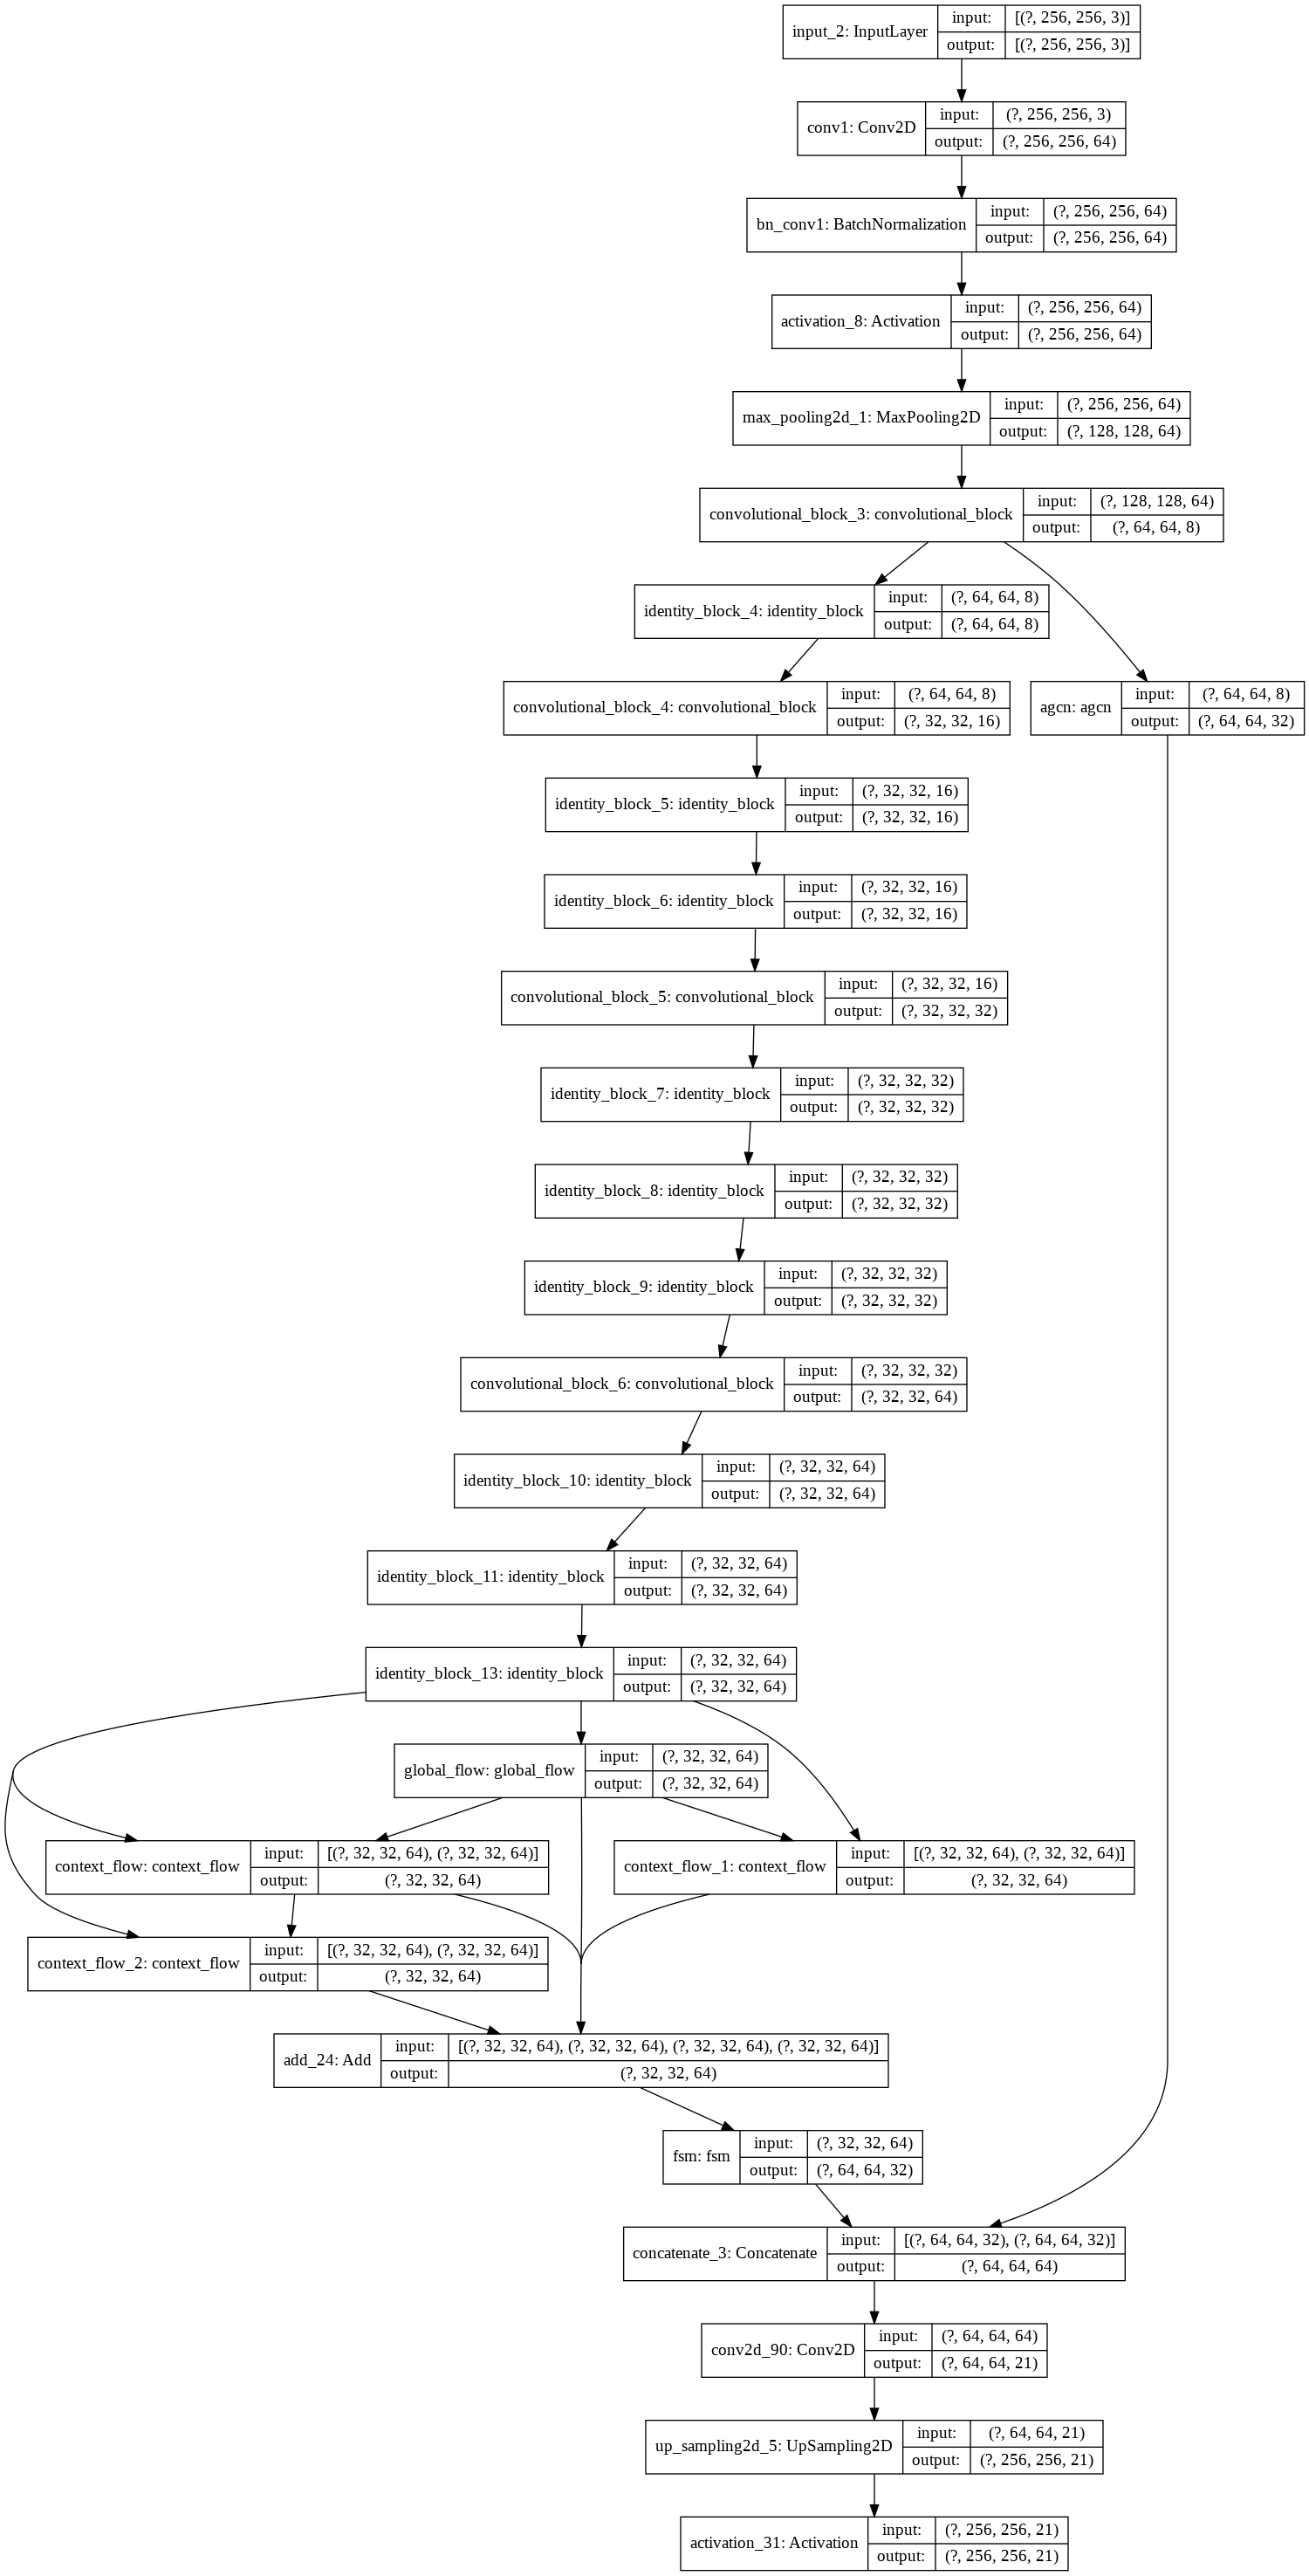

In [ ]:
tf.keras.utils.plot_model(model, to_file='model4.png', show_shapes=True, show_layer_names=True)

In [ ]:
def visualize(**images):
  n = len(images)
  plt.figure(figsize=(16, 5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    if i==1:
      plt.imshow(image, cmap='gray', vmax=1, vmin=0)
    else:
      plt.imshow(image)
    plt.show()
class Dataset:
  CLASSES = list(np.unique(list(label_clr.values())))
  # the parameters needs to changed based on your requirements
  # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
  # ex: fil_name.jpg file_name.mask.jpg
  def __init__(self , basepath , images_file_names , mask_file_names , CLASSES):
    self.image_ids = images_file_names
    self.mask_ids = mask_file_names
    # the paths of images
    self.images_fps = [os.path.join(basepath,image_id) for image_id in self.image_ids]
    # the paths of segmentation images
    self.masks_fps = [os.path.join(basepath,mask_id) for mask_id in self.mask_ids]
    # giving labels for each class
    self.CLASSES= CLASSES
    self.class_values = CLASSES
  def __getitem__(self, i):
    # read dataimage = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(mask,(256,256))
    image_masks = [(image_mask == v) for v in self.class_values]
    image_mask = np.stack(image_masks, axis=-1).astype('float')
    if self.images_fps[i] in X_train:
      a = np.random.uniform()
      if a<0.2:
        image = aug2.augment_image(image)
        image_mask = aug2.augment_image(image_mask)
      elif a<0.4:
        image = aug3.augment_image(image)
        image_mask = aug3.augment_image(image_mask)
      elif a<0.6:
        image = aug4.augment_image(image)
        image_mask = aug4.augment_image(image_mask)
      elif a<0.8:
        image = aug5.augment_image(image)
        image_mask = image_mask
      else:
        image = aug6.augment_image(image)
        image_mask = aug6.augment_image(image_mask)
    return image, image_mask
  def __len__(self):
    return len(self.image_ids)
class Dataloder(tf.keras.utils.Sequence):
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))
  def __getitem__(self, i):
    # collect batch data
    start = i * self.batch_size
    stop = (i + 1) * self.batch_size
    data = []
    for j in range(start, stop):
      data.append(self.dataset[j])
    batch = [np.stack(samples, axis=0) for samples in zip(*data)]
    return tuple(batch)
  def __len__(self):
    return len(self.indexes) // self.batch_size
  def on_epoch_end(self):
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)

In [ ]:
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
class AchieveTarget(Callback):
  def __init__(self, target):
    super(AchieveTarget, self).__init__()
    self.target = target
  def on_epoch_end(self, epoch, logs={}):
    acc = logs['val_iou_score']
    if acc >= self.target:
      self.model.stop_training = True

In [ ]:
CLASSES = list(np.unique(list(label_clr.values())))

In [ ]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
import datetime
!rm -rf '/content/logs'
CLASSES = CLASSES
basepath = '/content/'
train_dataset = Dataset(basepath, X_train['image'].values, X_train['mask'].values, CLASSES=CLASSES)
test_dataset = Dataset(basepath, X_test['image'].values, X_test['mask'].values, CLASSES=CLASSES)
train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb= tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
checkpoint = ModelCheckpoint('./best_model.h5', save_weights_only=True,save_best_only=True, mode='min', monitor='val_accuracy')
red = ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=1)
target = AchieveTarget(0.4)
callbacks_list =[checkpoint,tensorboard_cb,red,target,]

(8, 256, 256, 3)
(8, 256, 256, 21)


In [6]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5,validation_data=test_dataloader,callbacks=callbacks_list)

Epoch 1/5
335/335 [==============================] - 249s 742ms/step - loss: 0.6192 - iou_score: 0.3388 - val_loss: 0.6329- val_iou_score: 0.3470 - lr: 0.0010
Epoch 2/5
335/335 [==============================] - 248s 739ms/step - loss: 0.5955 - iou_score: 0.3573 - val_loss: 0.5926- val_iou_score: 0.3607 - lr: 1.0000e-04
Epoch 3/5
335/335 [==============================] - 249s 743ms/step - loss: 0.5897 - iou_score: 0.3620 - val_loss: 0.5907- val_iou_score: 0.3623 - lr: 1.0000e-05
Epoch 4/5
335/335 [==============================] - 248s 742ms/step - loss: 0.5886 - iou_score: 0.3629 - val_loss: 0.5904- val_iou_score: 0.3625 - lr: 1.0000e-06
Epoch 5/5
335/335 [==============================] - 248s 741ms/step - loss: 0.5885 - iou_score: 0.3630 - val_loss: 0.5903- val_iou_score: 0.3626 - lr: 1.0000e-06


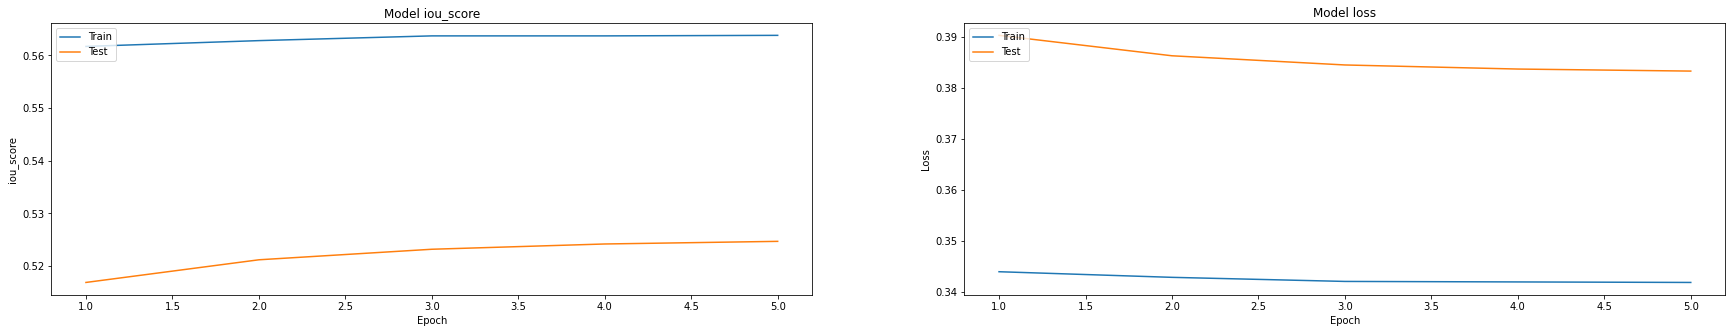

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

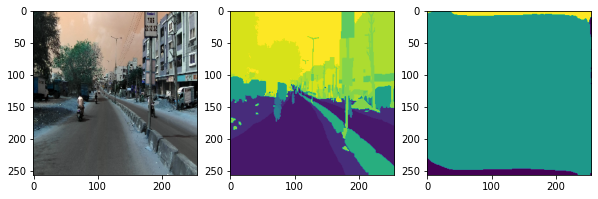

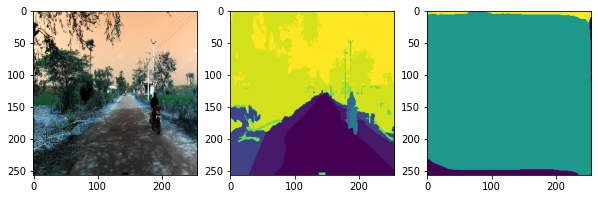

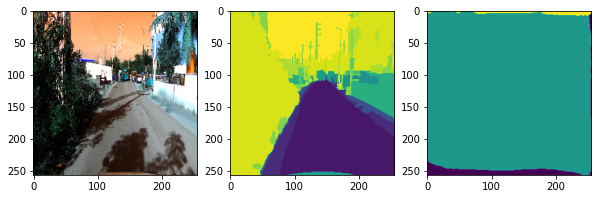

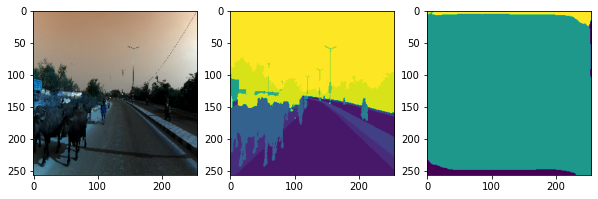

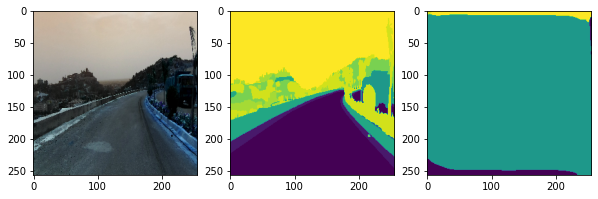

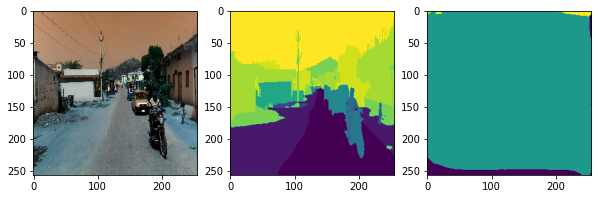

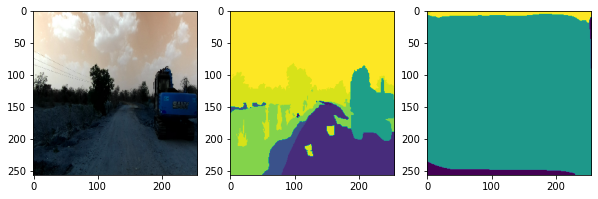

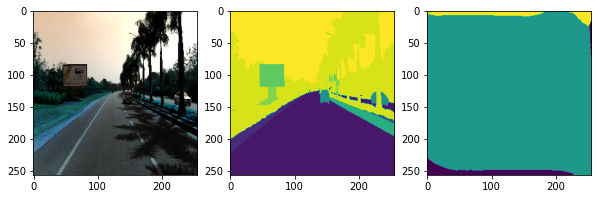

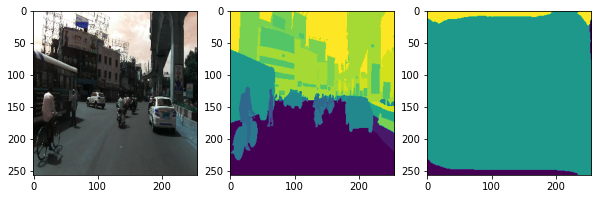

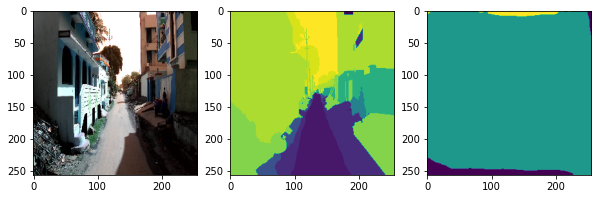

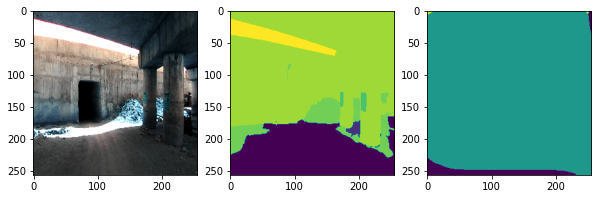

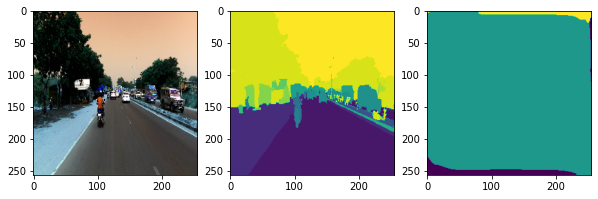

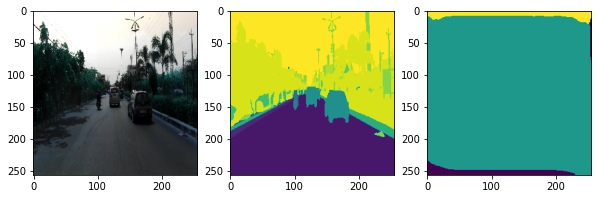

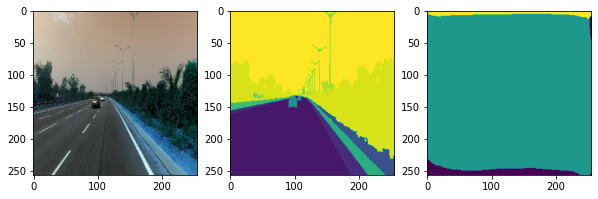

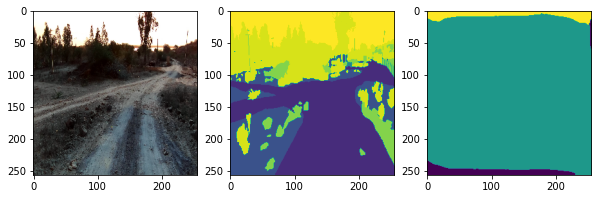

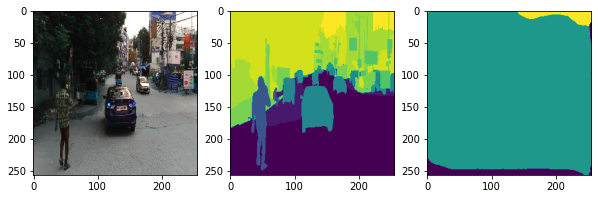

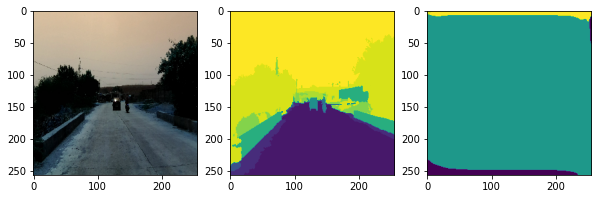

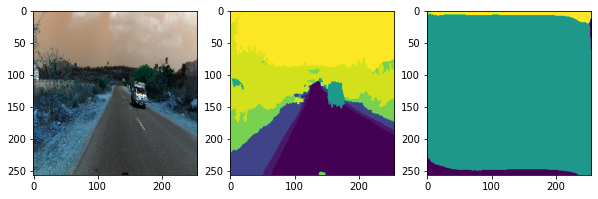

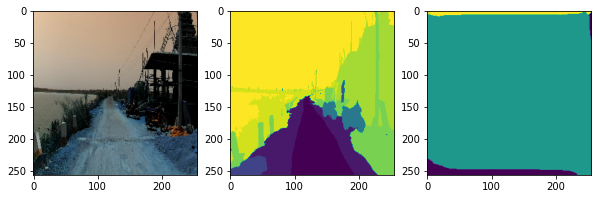

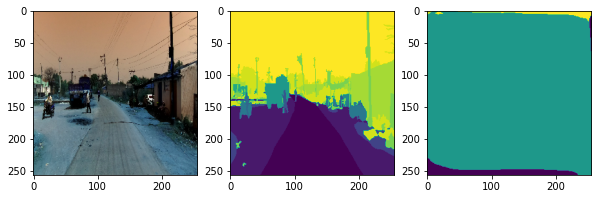

In [ ]:
b=0
for i in range(len(X_test)):
  b+=1
  #original image
  image = cv2.imread(list(X_test['image'])[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST)
  #predicted segmentation map
  pred_mask = model.predict(image[np.newaxis,:,:,:])
  pred_mask = tf.argmax(pred_mask, axis=-1)
  #original segmentation map
  image_mask = cv2.imread(list(X_test['mask'])[i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.subplot(133)
  plt.imshow(pred_mask[0])
  plt.show()
  if b==20:
    break

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations